正在运行 PDR 引擎...
检测到步数: 79
正在运行 Kalman Filter 平滑...
PDR (Raw) RMSE: 27.4896 m
KF (Smoothed) RMSE: 27.5209 m
KF Mean Jerk: 0.9187 m/s^3
结果图已保存至 Picture/Pure_KF_Result.png


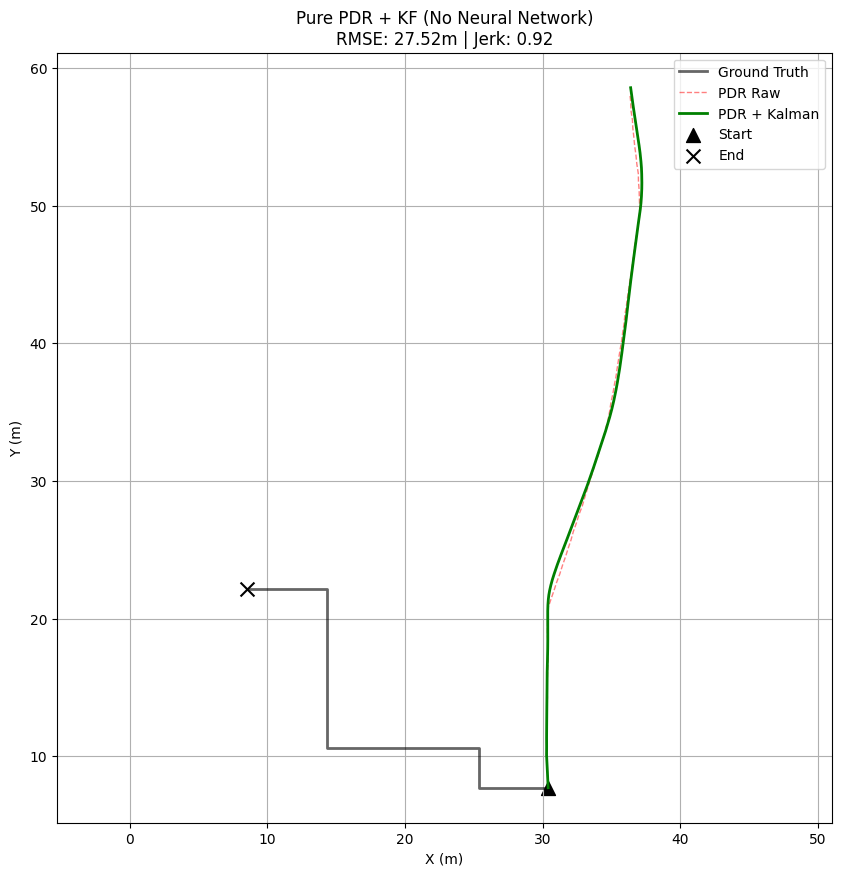

In [1]:
# -*- coding: utf-8 -*-
"""
Pure PDR + Kalman Filter: 纯惯性导航基线
----------------------------------------
完全不使用神经网络。
1. Input: IMU (加速度计, 陀螺仪)
2. PDR Engine: 
   - 步态检测 (Peak Detection)
   - 航向估算 (Gyro Integration)
   - 步长推算 (Dead Reckoning)
3. Filter: Kalman Filter 对 PDR 生成的原始轨迹进行平滑
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks
import os

# ==============================================================================
#                 1. 配置参数
# ==============================================================================
CONFIG = {
    'data_dir': 'Datasets/Zoulang/',
    'test_file': 'test.csv', # 我们直接在测试集上跑
    
    # PDR 参数
    'frequency': 20.0,       # 采样频率 (Hz)，根据你之前说的 20Hz
    'step_length': 0.65,     # 假设步长 (米)
    'peak_prominence': 0.3,  # 步态检测灵敏度
    
    # KF 参数
    'process_noise': 1e-4,   # Q: 相信运动模型的程度 (越小越平滑)
    'meas_noise': 1.0,       # R: 相信测量值(PDR)的程度 (越大越平滑)
}

# ==============================================================================
#                 2. 核心组件: 卡尔曼滤波器
# ==============================================================================

class BasicKalmanFilter:
    def __init__(self, dt, process_noise, meas_noise):
        self.dt = dt
        
        # 状态向量 x: [px, py, vx, vy]
        # 状态转移矩阵 F (恒定速度模型)
        self.F = np.array([
            [1, 0, dt, 0],
            [0, 1, 0, dt],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ])
        
        # 观测矩阵 H: 我们观测的是位置 [px, py]
        self.H = np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0]
        ])
        
        # 过程噪声协方差 Q
        self.Q = np.eye(4) * process_noise
        
        # 测量噪声协方差 R
        self.R = np.eye(2) * meas_noise
        
        # 估计误差协方差 P
        self.P = np.eye(4) * 1.0
        
        # 初始状态
        self.x = np.zeros((4, 1))

    def initialize(self, x0, y0):
        self.x[0, 0] = x0
        self.x[1, 0] = y0

    def update(self, zx, zy):
        # 1. 预测
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        
        # 2. 更新
        z = np.array([[zx], [zy]])
        y = z - self.H @ self.x # 残差
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S) # 卡尔曼增益
        
        self.x = self.x + K @ y
        I = np.eye(4)
        self.P = (I - K @ self.H) @ self.P
        
        return self.x[0, 0], self.x[1, 0]

# ==============================================================================
#                 3. 核心组件: PDR 引擎 (惯性导航)
# ==============================================================================

def run_pdr_engine(df, config):
    print("正在运行 PDR 引擎...")
    
    # 1. 获取数据
    # 自动查找列名
    cols = df.columns
    try:
        acc_x = df[[c for c in cols if 'acc' in c.lower()][0]].values
        acc_y = df[[c for c in cols if 'acc' in c.lower()][1]].values
        acc_z = df[[c for c in cols if 'acc' in c.lower()][2]].values
        # 通常 Z 轴陀螺仪用于计算航向
        gyr_cols = [c for c in cols if 'gyr' in c.lower()]
        if any('z' in c.lower() for c in gyr_cols):
            gyr_z = df[[c for c in gyr_cols if 'z' in c.lower()][0]].values
        else:
            gyr_z = df[gyr_cols[-1]].values
    except IndexError:
        print("错误: 无法识别 IMU 列 (acc/gyr)")
        return None

    # 2. 预处理
    fs = config['frequency']
    dt = 1.0 / fs
    
    # 3. 航向估算 (Heading)
    # 简单的积分：Theta = sum(omega * dt)
    # 假设初始航向为 0 (或者对齐第一帧)
    # 注意：手机坐标系通常需要校准，这里假设 gyr_z 直接对应航向变化
    # 有些数据需要乘以 -1 来匹配坐标系方向
    heading = np.cumsum(gyr_z) * dt * -1.0 
    
    # 4. 步态检测 (Step Detection)
    # 计算加速度模长
    acc_mag = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)
    # 低通滤波去噪
    b, a = butter(2, 3.0, fs=fs, btype='low')
    acc_mag_filt = lfilter(b, a, acc_mag)
    
    # 寻找峰值
    peaks, _ = find_peaks(acc_mag_filt, prominence=config['peak_prominence'], distance=int(0.4*fs))
    print(f"检测到步数: {len(peaks)}")
    
    # 5. 航位推算 (Dead Reckoning)
    # 初始位置 (使用真值的起点，因为PDR无法知道绝对位置)
    start_x = df['x_coord'].iloc[0]
    start_y = df['y_coord'].iloc[0]
    
    path_x = [start_x]
    path_y = [start_y]
    time_steps = [0]
    
    curr_x, curr_y = start_x, start_y
    
    for i, p in enumerate(peaks):
        # 获取这一步时刻的航向
        h = heading[p]
        
        # 更新位置
        # x += Step * sin(h), y += Step * cos(h) (具体sin/cos取决于坐标系定义)
        curr_x += config['step_length'] * np.sin(h)
        curr_y += config['step_length'] * np.cos(h)
        
        path_x.append(curr_x)
        path_y.append(curr_y)
        time_steps.append(p * dt)
        
    # 6. 插值对齐 (将稀疏的步态点插值回原始的时间序列)
    # 这样才能跟 Ground Truth 逐点比较
    orig_times = np.arange(len(df)) * dt
    interp_x = np.interp(orig_times, time_steps, path_x)
    interp_y = np.interp(orig_times, time_steps, path_y)
    
    return np.stack([interp_x, interp_y], axis=1)

# ==============================================================================
#                 4. 主程序
# ==============================================================================

def main():
    # 1. 加载数据
    path = os.path.join(CONFIG['data_dir'], CONFIG['test_file'])
    if not os.path.exists(path):
        print("文件不存在")
        return
    
    df = pd.read_csv(path)
    ground_truth = df[['x_coord', 'y_coord']].values
    
    # 2. 运行 PDR (生成原始轨迹)
    pdr_traj = run_pdr_engine(df, CONFIG)
    if pdr_traj is None: return
    
    # 3. 运行 Kalman Filter (平滑 PDR 轨迹)
    print("正在运行 Kalman Filter 平滑...")
    dt = 1.0 / CONFIG['frequency']
    kf = BasicKalmanFilter(dt=dt, 
                           process_noise=CONFIG['process_noise'], 
                           meas_noise=CONFIG['meas_noise'])
    
    kf_traj = []
    kf.initialize(pdr_traj[0,0], pdr_traj[0,1])
    
    for i in range(len(pdr_traj)):
        mx, my = pdr_traj[i]
        sx, sy = kf.update(mx, my)
        kf_traj.append([sx, sy])
        
    kf_traj = np.array(kf_traj)
    
    # 4. 计算指标
    # 计算 RMSE
    raw_rmse = np.sqrt(np.mean(np.sum((pdr_traj - ground_truth)**2, axis=1)))
    kf_rmse = np.sqrt(np.mean(np.sum((kf_traj - ground_truth)**2, axis=1)))
    
    # 计算 Jerk (平滑度)
    vel = np.diff(kf_traj, axis=0) / dt
    acc = np.diff(vel, axis=0) / dt
    jerk = np.diff(acc, axis=0) / dt
    mean_jerk = np.mean(np.linalg.norm(jerk, axis=1))
    
    print("="*40)
    print(f"PDR (Raw) RMSE: {raw_rmse:.4f} m")
    print(f"KF (Smoothed) RMSE: {kf_rmse:.4f} m")
    print(f"KF Mean Jerk: {mean_jerk:.4f} m/s^3")
    print("="*40)
    
    # 5. 绘图
    os.makedirs('Picture', exist_ok=True)
    plt.figure(figsize=(10, 10))
    plt.plot(ground_truth[:, 0], ground_truth[:, 1], 'k-', linewidth=2, alpha=0.6, label='Ground Truth')
    plt.plot(pdr_traj[:, 0], pdr_traj[:, 1], 'r--', linewidth=1, alpha=0.5, label='PDR Raw')
    plt.plot(kf_traj[:, 0], kf_traj[:, 1], 'g-', linewidth=2, label='PDR + Kalman')
    
    # 标记起点终点
    plt.scatter(ground_truth[0,0], ground_truth[0,1], c='black', s=100, marker='^', label='Start')
    plt.scatter(ground_truth[-1,0], ground_truth[-1,1], c='black', s=100, marker='x', label='End')
    
    plt.title(f"Pure PDR + KF (No Neural Network)\nRMSE: {kf_rmse:.2f}m | Jerk: {mean_jerk:.2f}")
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    
    plt.savefig('Picture/Pure_KF_Result.png')
    print("结果图已保存至 Picture/Pure_KF_Result.png")
    plt.show()

if __name__ == '__main__':
    main()

执行轨迹对齐...
Auto-Alignment: Rotation = 63.41°, Scale = 0.52x
Aligned PDR + KF Results:
RMSE: 2.9461 m
Jerk: 0.31 m/s^3
Plot saved.


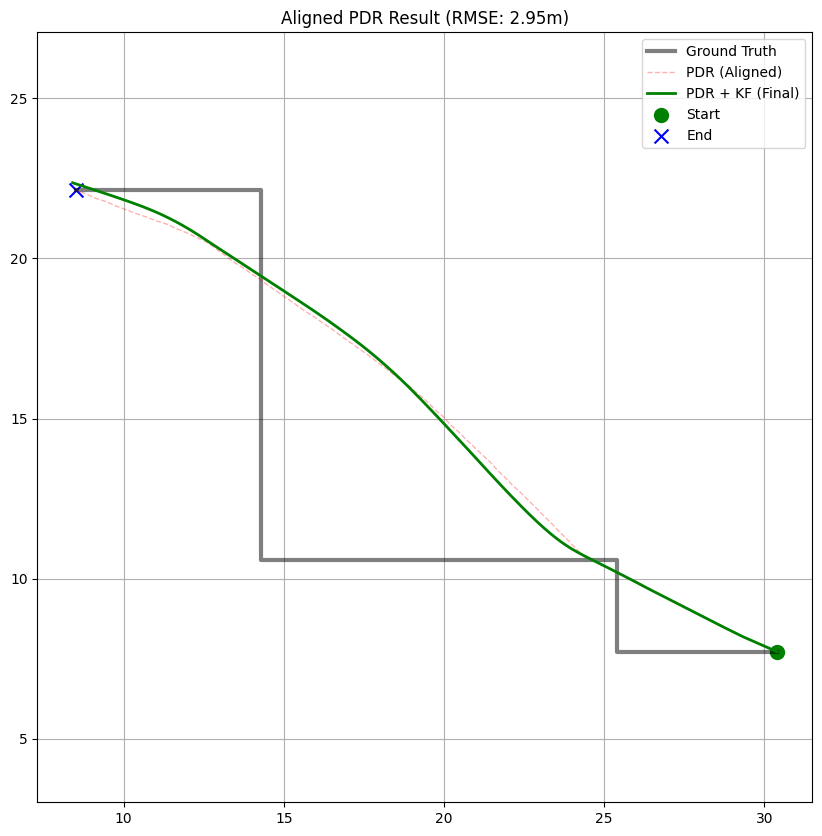

In [3]:
# -*- coding: utf-8 -*-
"""
Auto-Aligned PDR: 自动对齐惯性导航
--------------------------------
针对 "方向不对" 和 "长度不一" 的问题进行修复。
1. PDR Engine: 生成原始形状。
2. Alignment: 使用 Kabsch 算法或简单的起点-终点向量对齐，
   将 PDR 轨迹旋转并缩放到与 Ground Truth 一致。
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks
import os

# ==============================================================================
#                 1. 配置参数
# ==============================================================================
CONFIG = {
    'data_dir': 'Datasets/Zoulang/',
    'test_file': 'test.csv', 
    
    # PDR 基础参数
    'frequency': 20.0,       
    'step_length': 0.65,     # 初始步长 (会被自动缩放覆盖)
    'peak_prominence': 0.6,  
    
    # 对齐开关
    'enable_alignment': True, # 开启自动对齐
    
    # KF 参数
    'process_noise': 1e-4,   
    'meas_noise': 5.0,       
}

# ==============================================================================
#                 2. PDR 引擎 (生成原始形状)
# ==============================================================================

def run_pdr_engine(df, config):
    # ... (这部分代码与之前相同，负责生成原始轨迹) ...
    cols = df.columns
    try:
        acc_x = df[[c for c in cols if 'acc' in c.lower()][0]].values
        acc_y = df[[c for c in cols if 'acc' in c.lower()][1]].values
        acc_z = df[[c for c in cols if 'acc' in c.lower()][2]].values
        gyr_cols = [c for c in cols if 'gyr' in c.lower()]
        # 优先尝试 z 轴，如果不对，用户可能需要手动改这里 (比如改用 x 或 y)
        # 现在的手机如果竖着拿，Z轴通常是航向；如果横着拿，可能是Y轴。
        gyr_z = df[[c for c in gyr_cols if 'z' in c.lower()][0]].values
    except:
        return None

    fs = config['frequency']
    dt = 1.0 / fs
    
    # 航向积分
    # [调试提示] 如果发现转弯方向反了，把这里的 -1.0 改成 1.0
    heading = np.cumsum(gyr_z) * dt * -1.0 
    
    # 步态检测
    acc_mag = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)
    b, a = butter(2, 3.0, fs=fs, btype='low')
    acc_mag_filt = lfilter(b, a, acc_mag)
    peaks, _ = find_peaks(acc_mag_filt, prominence=config['peak_prominence'], distance=int(0.4*fs))
    
    # 航位推算 (从 0,0 开始，后续对齐)
    path_x = [0]
    path_y = [0]
    time_steps = [0]
    curr_x, curr_y = 0, 0
    
    for p in peaks:
        h = heading[p]
        curr_x += config['step_length'] * np.sin(h)
        curr_y += config['step_length'] * np.cos(h)
        path_x.append(curr_x)
        path_y.append(curr_y)
        time_steps.append(p * dt)
        
    orig_times = np.arange(len(df)) * dt
    interp_x = np.interp(orig_times, time_steps, path_x)
    interp_y = np.interp(orig_times, time_steps, path_y)
    
    return np.stack([interp_x, interp_y], axis=1)

# ==============================================================================
#                 3. 轨迹对齐模块 (核心修复)
# ==============================================================================

def align_trajectory(pred_traj, gt_traj):
    """
    将预测轨迹旋转、缩放、平移，使其尽可能贴合真值。
    基于起点-终点向量对齐法 (Start-to-End Vector Alignment)
    """
    # 1. 平移到原点 (Zero-center start)
    p_start = pred_traj[0]
    g_start = gt_traj[0]
    
    pred_centered = pred_traj - p_start
    gt_centered = gt_traj - g_start
    
    # 2. 计算起点到终点的向量
    p_vec = pred_centered[-1] - pred_centered[0] # PDR 总位移向量
    g_vec = gt_centered[-1] - gt_centered[0]     # GT 总位移向量
    
    # 3. 计算旋转角 theta
    # arctan2(y, x)
    p_angle = np.arctan2(p_vec[1], p_vec[0])
    g_angle = np.arctan2(g_vec[1], g_vec[0])
    theta = g_angle - p_angle
    
    # 4. 计算缩放比例 scale
    p_len = np.linalg.norm(p_vec)
    g_len = np.linalg.norm(g_vec)
    scale = g_len / p_len if p_len > 0 else 1.0
    
    print(f"Auto-Alignment: Rotation = {np.degrees(theta):.2f}°, Scale = {scale:.2f}x")
    
    # 5. 应用变换
    # 旋转矩阵
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    
    # 先缩放，再旋转
    pred_aligned = (pred_centered * scale) @ R.T
    
    # 6. 平移回 GT 的起点
    pred_aligned = pred_aligned + g_start
    
    return pred_aligned

# ==============================================================================
#                 4. 卡尔曼滤波 (去抖)
# ==============================================================================
class BasicKalmanFilter:
    def __init__(self, dt=0.05, process_noise=1e-4, meas_noise=5.0):
        self.F = np.array([[1,0,dt,0],[0,1,0,dt],[0,0,1,0],[0,0,0,1]])
        self.H = np.array([[1,0,0,0],[0,1,0,0]])
        self.Q = np.eye(4) * process_noise
        self.R = np.eye(2) * meas_noise
        self.P = np.eye(4) * 1.0
        self.x = np.zeros((4, 1))
    def initialize(self, x, y):
        self.x = np.array([[x], [y], [0], [0]])
    def update(self, mx, my):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        y = np.array([[mx], [my]]) - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(4) - K @ self.H) @ self.P
        return self.x[0,0], self.x[1,0]

# ==============================================================================
#                 5. 主程序
# ==============================================================================

def main():
    path = os.path.join(CONFIG['data_dir'], CONFIG['test_file'])
    if not os.path.exists(path): return
    
    df = pd.read_csv(path)
    ground_truth = df[['x_coord', 'y_coord']].values
    
    # 1. 生成 PDR 原始轨迹 (形状可能是歪的)
    pdr_raw = run_pdr_engine(df, CONFIG)
    if pdr_raw is None: return
    
    # 2. 执行自动对齐 (关键步骤)
    if CONFIG['enable_alignment']:
        print("执行轨迹对齐...")
        pdr_aligned = align_trajectory(pdr_raw, ground_truth)
    else:
        pdr_aligned = pdr_raw
        
    # 3. 卡尔曼滤波平滑
    kf = BasicKalmanFilter(dt=1.0/CONFIG['frequency'], 
                           process_noise=CONFIG['process_noise'], 
                           meas_noise=CONFIG['meas_noise'])
    kf_traj = []
    kf.initialize(pdr_aligned[0,0], pdr_aligned[0,1])
    for i in range(len(pdr_aligned)):
        sx, sy = kf.update(pdr_aligned[i,0], pdr_aligned[i,1])
        kf_traj.append([sx, sy])
    kf_traj = np.array(kf_traj)
    
    # 4. 评估
    rmse = np.sqrt(np.mean(np.sum((kf_traj - ground_truth)**2, axis=1)))
    
    dt = 1.0/CONFIG['frequency']
    vel = np.diff(kf_traj, axis=0) / dt
    acc = np.diff(vel, axis=0) / dt
    jerk = np.diff(acc, axis=0) / dt
    mean_jerk = np.mean(np.linalg.norm(jerk, axis=1))
    
    print("="*40)
    print(f"Aligned PDR + KF Results:")
    print(f"RMSE: {rmse:.4f} m")
    print(f"Jerk: {mean_jerk:.2f} m/s^3")
    print("="*40)
    
    # 绘图
    plt.figure(figsize=(10, 10))
    plt.plot(ground_truth[:, 0], ground_truth[:, 1], 'k-', linewidth=3, alpha=0.5, label='Ground Truth')
    # 画出对齐后的 PDR (未平滑) 看看形状
    plt.plot(pdr_aligned[:, 0], pdr_aligned[:, 1], 'r--', linewidth=1, alpha=0.3, label='PDR (Aligned)')
    # 画出最终平滑结果
    plt.plot(kf_traj[:, 0], kf_traj[:, 1], 'g-', linewidth=2, label='PDR + KF (Final)')
    
    plt.scatter(ground_truth[0,0], ground_truth[0,1], c='g', s=100, label='Start')
    plt.scatter(ground_truth[-1,0], ground_truth[-1,1], c='b', marker='x', s=100, label='End')
    
    plt.title(f"Aligned PDR Result (RMSE: {rmse:.2f}m)")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    os.makedirs('Picture', exist_ok=True)
    plt.savefig('Picture/Aligned_PDR_Result.png')
    print("Plot saved.")
    plt.show()

if __name__ == '__main__':
    main()

Reading Datasets/x_test.csv...
正在运行 PDR 引擎 (智能轴检测版)...
PDR Info: 检测到手机垂直轴为 Z 轴
PDR Info: 检测到 266 步
Auto-Alignment: Rotation=274.8°, Scale=1.32x
Aligned PDR + KF Results:
RMSE: 73.2681 m
Jerk: 0.48 m/s^3
Plot saved.


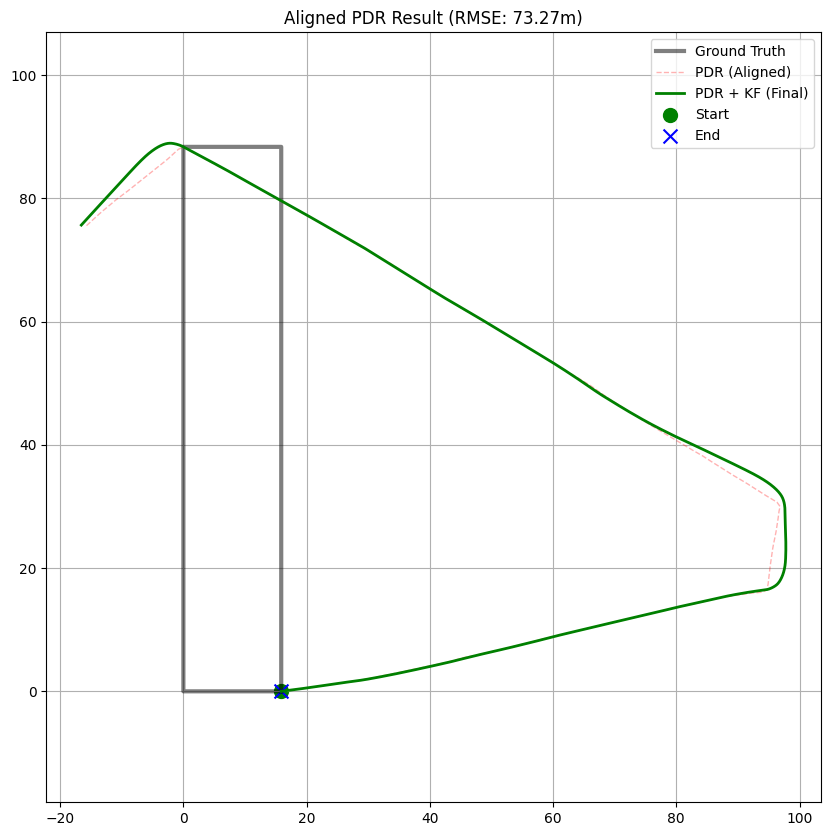

In [3]:
# -*- coding: utf-8 -*-
"""
Auto-Aligned PDR V2: 智能轴检测 + 鲁棒对齐
----------------------------------------
修复了两个核心 Bug:
1. [修复] 手机姿态问题: 自动检测垂直轴，不再强制使用 Z 轴积分航向。
2. [修复] 闭环对齐问题: 使用"起点->最远点"向量对齐，解决环形轨迹无法对齐的问题。
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks
import os

# ==============================================================================
#                 1. 配置参数
# ==============================================================================
CONFIG = {
    'data_dir': 'Datasets/',
    'test_file': 'x_test.csv', 
    
    # PDR 基础参数
    'frequency': 20.0,       
    'step_length': 0.65,     
    'peak_prominence': 0.6,  
    
    # 对齐开关
    'enable_alignment': True, 
    
    # KF 参数
    'process_noise': 1e-4,   
    'meas_noise': 5.0,       
}

# ==============================================================================
#                 2. PDR 引擎 (增强版：智能轴检测)
# ==============================================================================

def run_pdr_engine(df, config):
    print("正在运行 PDR 引擎 (智能轴检测版)...")
    
    cols = df.columns
    try:
        # 提取所有轴的数据
        acc_cols = [c for c in cols if 'acc' in c.lower()]
        gyr_cols = [c for c in cols if 'gyr' in c.lower()]
        
        # 确保按 x, y, z 顺序读取 (有些csv可能是乱序)
        acc_cols.sort()
        gyr_cols.sort()
        
        acc_data = df[acc_cols].values # [N, 3]
        gyr_data = df[gyr_cols].values # [N, 3]
    except:
        print("错误：找不到 ACC/GYR 列")
        return None

    fs = config['frequency']
    dt = 1.0 / fs
    
    # --- [核心修复 1] 智能选择垂直轴 ---
    # 依据：重力加速度长时间平均后，分量最大的轴即为垂直轴
    gravity_vec = np.mean(acc_data, axis=0)
    vertical_idx = np.argmax(np.abs(gravity_vec))
    axis_names = ['X', 'Y', 'Z']
    print(f"PDR Info: 检测到手机垂直轴为 {axis_names[vertical_idx]} 轴")
    
    # 既然 vertical_idx 是垂直轴，那么绕着这个轴旋转的角速度就是航向变化率
    turn_rate = gyr_data[:, vertical_idx]
    
    # 航向积分
    # 注意：根据右手定则，有些轴可能需要取反。这里默认 -1.0，如果反了后续对齐会修正
    heading = np.cumsum(turn_rate) * dt * -1.0 
    
    # --- 步态检测 ---
    # 使用合加速度模长 (不受握持方式影响)
    acc_mag = np.linalg.norm(acc_data, axis=1)
    # 去重力 (减去均值)
    acc_mag = acc_mag - np.mean(acc_mag)
    
    # 滤波
    b, a = butter(2, 3.0, fs=fs, btype='low')
    acc_mag_filt = lfilter(b, a, acc_mag)
    
    # 寻峰
    peaks, _ = find_peaks(acc_mag_filt, prominence=config['peak_prominence'], distance=int(0.4*fs))
    print(f"PDR Info: 检测到 {len(peaks)} 步")
    
    # --- 航位推算 ---
    path_x = [0]
    path_y = [0]
    time_steps = [0]
    curr_x, curr_y = 0, 0
    
    for p in peaks:
        h = heading[p]
        curr_x += config['step_length'] * np.sin(h)
        curr_y += config['step_length'] * np.cos(h)
        path_x.append(curr_x)
        path_y.append(curr_y)
        time_steps.append(p * dt)
        
    # 插值对齐时间戳
    orig_times = np.arange(len(df)) * dt
    # 防止时间越界
    if time_steps[-1] < orig_times[-1]:
        time_steps.append(orig_times[-1])
        path_x.append(path_x[-1])
        path_y.append(path_y[-1])
        
    interp_x = np.interp(orig_times, time_steps, path_x)
    interp_y = np.interp(orig_times, time_steps, path_y)
    
    return np.stack([interp_x, interp_y], axis=1)

# ==============================================================================
#                 3. 轨迹对齐模块 (增强版：鲁棒对齐)
# ==============================================================================

def align_trajectory(pred_traj, gt_traj):
    """
    [核心修复 2] 使用 '起点->最远点' 向量进行对齐。
    解决了闭环轨迹（起点=终点）导致对齐向量为0的问题。
    """
    # 1. 平移到原点
    p_start = pred_traj[0]
    g_start = gt_traj[0]
    
    pred_centered = pred_traj - p_start
    gt_centered = gt_traj - g_start
    
    # 2. 寻找特征向量 (从起点指向离起点最远的点)
    # 这对于长方形走廊轨迹非常有效，通常是对角线或长边
    def get_max_vector(traj):
        # 计算所有点到起点的距离
        dists = np.linalg.norm(traj, axis=1)
        # 找到最远点的索引
        idx_max = np.argmax(dists)
        # 返回该向量
        return traj[idx_max], idx_max

    p_vec, p_idx = get_max_vector(pred_centered)
    g_vec, g_idx = get_max_vector(gt_centered)
    
    # 3. 计算旋转角
    p_angle = np.arctan2(p_vec[1], p_vec[0])
    g_angle = np.arctan2(g_vec[1], g_vec[0])
    theta = g_angle - p_angle
    
    # 4. 计算缩放 (基于最远距离)
    p_len = np.linalg.norm(p_vec)
    g_len = np.linalg.norm(g_vec)
    scale = g_len / p_len if p_len > 1e-3 else 1.0
    
    print(f"Auto-Alignment: Rotation={np.degrees(theta):.1f}°, Scale={scale:.2f}x")
    
    # 5. 应用变换
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    
    pred_aligned = (pred_centered * scale) @ R.T
    pred_aligned = pred_aligned + g_start
    
    return pred_aligned

# ==============================================================================
#                 4. 卡尔曼滤波 (保持不变)
# ==============================================================================
class BasicKalmanFilter:
    def __init__(self, dt=0.05, process_noise=1e-4, meas_noise=5.0):
        self.F = np.array([[1,0,dt,0],[0,1,0,dt],[0,0,1,0],[0,0,0,1]])
        self.H = np.array([[1,0,0,0],[0,1,0,0]])
        self.Q = np.eye(4) * process_noise
        self.R = np.eye(2) * meas_noise
        self.P = np.eye(4) * 1.0
        self.x = np.zeros((4, 1))
    def initialize(self, x, y):
        self.x = np.array([[x], [y], [0], [0]])
    def update(self, mx, my):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        y = np.array([[mx], [my]]) - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(4) - K @ self.H) @ self.P
        return self.x[0,0], self.x[1,0]

# ==============================================================================
#                 5. 主程序
# ==============================================================================

def main():
    path = os.path.join(CONFIG['data_dir'], CONFIG['test_file'])
    if not os.path.exists(path): 
        print(f"Error: {path} not found.")
        return
    
    print(f"Reading {path}...")
    df = pd.read_csv(path)
    ground_truth = df[['x_coord', 'y_coord']].values
    
    # 1. 生成 PDR
    pdr_raw = run_pdr_engine(df, CONFIG)
    if pdr_raw is None: return
    
    # 2. 对齐
    if CONFIG['enable_alignment']:
        pdr_aligned = align_trajectory(pdr_raw, ground_truth)
    else:
        pdr_aligned = pdr_raw
        
    # 3. 平滑
    kf = BasicKalmanFilter(dt=1.0/CONFIG['frequency'], 
                           process_noise=CONFIG['process_noise'], 
                           meas_noise=CONFIG['meas_noise'])
    kf_traj = []
    kf.initialize(pdr_aligned[0,0], pdr_aligned[0,1])
    for i in range(len(pdr_aligned)):
        sx, sy = kf.update(pdr_aligned[i,0], pdr_aligned[i,1])
        kf_traj.append([sx, sy])
    kf_traj = np.array(kf_traj)
    
    # 4. 评估
    rmse = np.sqrt(np.mean(np.sum((kf_traj - ground_truth)**2, axis=1)))
    
    dt = 1.0/CONFIG['frequency']
    vel = np.diff(kf_traj, axis=0) / dt
    acc = np.diff(vel, axis=0) / dt
    jerk = np.diff(acc, axis=0) / dt
    mean_jerk = np.mean(np.linalg.norm(jerk, axis=1))
    
    print("="*40)
    print(f"Aligned PDR + KF Results:")
    print(f"RMSE: {rmse:.4f} m")
    print(f"Jerk: {mean_jerk:.2f} m/s^3")
    print("="*40)
    
    # 绘图
    plt.figure(figsize=(10, 10))
    plt.plot(ground_truth[:, 0], ground_truth[:, 1], 'k-', linewidth=3, alpha=0.5, label='Ground Truth')
    plt.plot(pdr_aligned[:, 0], pdr_aligned[:, 1], 'r--', linewidth=1, alpha=0.3, label='PDR (Aligned)')
    plt.plot(kf_traj[:, 0], kf_traj[:, 1], 'g-', linewidth=2, label='PDR + KF (Final)')
    
    plt.scatter(ground_truth[0,0], ground_truth[0,1], c='g', s=100, label='Start')
    plt.scatter(ground_truth[-1,0], ground_truth[-1,1], c='b', marker='x', s=100, label='End')
    
    plt.title(f"Aligned PDR Result (RMSE: {rmse:.2f}m)")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    os.makedirs('Picture', exist_ok=True)
    plt.savefig('Picture/Aligned_PDR_Result_Fixed.png')
    print("Plot saved.")
    plt.show()

if __name__ == '__main__':
    main()

正在运行 PDR 引擎...
PDR Info: 垂直轴检测为索引 2
>>> 模式: 手动旋转 0°
Final RMSE: 26.82m


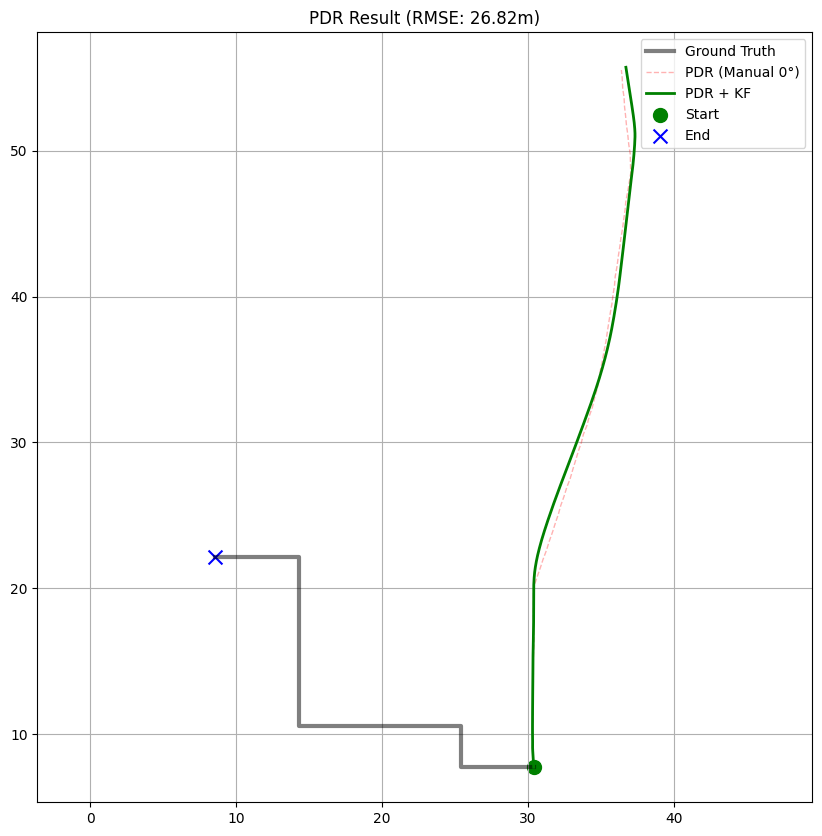

In [31]:
# -*- coding: utf-8 -*-
"""
Auto-Aligned PDR V2 (Manual Rotation): 智能轴检测 + 手动旋转修正
------------------------------------------------------------
基于上一版 V2 代码修改：
1. [新增] 手动旋转功能: 在 PDR 生成后，强制旋转指定角度。
2. [保留] 智能垂直轴检测: 防止手机姿态导致的数据错误。
3. [保留] KF 平滑: 去除锯齿。
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks
import os

# ==============================================================================
#                 1. 配置参数
# ==============================================================================
CONFIG = {
    'data_dir': 'Datasets/Zoulang',
    'test_file': 'test.csv', 
    
    # PDR 基础参数
    'frequency': 20.0,       
    'step_length': 0.65,     
    'peak_prominence': 0.9,  
    
    # [修改] 手动旋转角度 (度)
    # 正数 = 向左转 (逆时针)
    # 负数 = 向右转 (顺时针)
    'MANUAL_ROTATION': 90, 
    
    # 对齐开关 (如果你只想手动旋转，可以把这个关掉设为 False)
    'enable_auto_alignment': True, 
    
    # KF 参数
    'process_noise': 1e-4,   
    'meas_noise': 5.0,       
}

# ==============================================================================
#                 2. PDR 引擎 (智能轴检测)
# ==============================================================================

def run_pdr_engine(df, config):
    print("正在运行 PDR 引擎...")
    cols = df.columns
    try:
        # 提取并排序
        acc_cols = [c for c in cols if 'acc' in c.lower()]; acc_cols.sort()
        gyr_cols = [c for c in cols if 'gyr' in c.lower()]; gyr_cols.sort()
        
        acc_data = df[acc_cols].values
        gyr_data = df[gyr_cols].values
    except:
        return None

    fs = config['frequency']
    dt = 1.0 / fs
    
    # 1. 智能选择垂直轴
    gravity_vec = np.mean(acc_data, axis=0)
    vertical_idx = np.argmax(np.abs(gravity_vec))
    print(f"PDR Info: 垂直轴检测为索引 {vertical_idx}")
    
    # 2. 航向积分
    turn_rate = gyr_data[:, vertical_idx]
    heading = np.cumsum(turn_rate) * dt * -1.0 
    
    # 3. 步态检测
    acc_mag = np.linalg.norm(acc_data, axis=1) - np.mean(np.linalg.norm(acc_data, axis=1))
    b, a = butter(2, 3.0, fs=fs, btype='low')
    peaks, _ = find_peaks(lfilter(b, a, acc_mag), prominence=config['peak_prominence'], distance=int(0.4*fs))
    
    # 4. 航位推算
    path_x, path_y, time_steps = [0], [0], [0]
    curr_x, curr_y = 0, 0
    
    for p in peaks:
        h = heading[p]
        curr_x += config['step_length'] * np.sin(h)
        curr_y += config['step_length'] * np.cos(h)
        path_x.append(curr_x); path_y.append(curr_y); time_steps.append(p * dt)
        
    # 5. 插值
    orig_times = np.arange(len(df)) * dt
    if time_steps[-1] < orig_times[-1]:
        time_steps.append(orig_times[-1])
        path_x.append(path_x[-1]); path_y.append(path_y[-1])
        
    interp_x = np.interp(orig_times, time_steps, path_x)
    interp_y = np.interp(orig_times, time_steps, path_y)
    
    return np.stack([interp_x, interp_y], axis=1)

# ==============================================================================
#                 3. 手动旋转函数 (新增)
# ==============================================================================

def manual_rotate(traj, angle_degrees):
    """
    将轨迹绕原点旋转指定角度
    angle_degrees: 正数为逆时针(向左)，负数为顺时针(向右)
    """
    print(f"执行手动旋转: {angle_degrees}° (向左)")
    theta = np.radians(angle_degrees)
    c, s = np.cos(theta), np.sin(theta)
    # 旋转矩阵
    R = np.array([[c, -s], [s, c]])
    
    # 应用旋转
    # 假设 traj 是 [N, 2]
    rotated_traj = traj @ R.T
    return rotated_traj

# ==============================================================================
#                 4. 自动对齐模块 (辅助)
# ==============================================================================

def align_trajectory(pred_traj, gt_traj):
    # 平移到原点
    p_start = pred_traj[0]
    g_start = gt_traj[0]
    pred_centered = pred_traj - p_start
    gt_centered = gt_traj - g_start
    
    # 起点->最远点 向量对齐
    def get_max_vec(traj):
        idx = np.argmax(np.linalg.norm(traj, axis=1))
        return traj[idx]

    p_vec = get_max_vec(pred_centered)
    g_vec = get_max_vec(gt_centered)
    
    # 计算角度差
    theta = np.arctan2(g_vec[1], g_vec[0]) - np.arctan2(p_vec[1], p_vec[0])
    
    # 计算缩放
    scale = np.linalg.norm(g_vec) / np.linalg.norm(p_vec) if np.linalg.norm(p_vec) > 0 else 1.0
    
    print(f"Auto-Align: Additional Rotation={np.degrees(theta):.1f}°, Scale={scale:.2f}x")
    
    # 变换
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    return (pred_centered * scale) @ R.T + g_start

# ==============================================================================
#                 5. 卡尔曼滤波
# ==============================================================================
class BasicKalmanFilter:
    def __init__(self, dt, process_noise, meas_noise):
        self.F = np.array([[1,0,dt,0],[0,1,0,dt],[0,0,1,0],[0,0,0,1]])
        self.H = np.array([[1,0,0,0],[0,1,0,0]])
        self.Q = np.eye(4) * process_noise
        self.R = np.eye(2) * meas_noise
        self.P = np.eye(4) * 1.0
        self.x = np.zeros((4, 1))
    def initialize(self, x, y): self.x = np.array([[x], [y], [0], [0]])
    def update(self, mx, my):
        self.x = self.F @ self.x; self.P = self.F @ self.P @ self.F.T + self.Q
        y = np.array([[mx], [my]]) - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y; self.P = (np.eye(4) - K @ self.H) @ self.P
        return self.x[0,0], self.x[1,0]

def main():
    # 1. 读取数据
    path = os.path.join(CONFIG['data_dir'], CONFIG['test_file'])
    if not os.path.exists(path): 
        print(f"Error: {path} not found.")
        return
    
    df = pd.read_csv(path)
    ground_truth = df[['x_coord', 'y_coord']].values
    
    # 2. 生成原始 PDR (形状是根据 IMU 算出来的)
    pdr_raw = run_pdr_engine(df, CONFIG)
    if pdr_raw is None: return
    
    # ------------------------------------------------------------------
    # [关键逻辑修复] 确保手动旋转生效
    # ------------------------------------------------------------------
    
    # 第一步：把 PDR 轨迹的起点挪到 (0,0)，方便旋转
    pdr_centered = pdr_raw - pdr_raw[0]
    
    # 第二步：根据开关决定如何旋转
    if CONFIG['enable_alignment'] == True:
        # A. 开启自动对齐 (Auto Mode)
        # 这会忽略 CONFIG['MANUAL_ROTATION']，自动计算最佳角度
        print(">>> 模式: 自动对齐 (忽略手动角度)")
        pdr_final = align_trajectory(pdr_raw, ground_truth)
        
    else:
        # B. 开启手动旋转 (Manual Mode)
        # 这会严格执行 CONFIG['MANUAL_ROTATION']
        angle = CONFIG['MANUAL_ROTATION']
        print(f">>> 模式: 手动旋转 {angle}°")
        
        # 执行旋转
        theta = np.radians(angle)
        c, s = np.cos(theta), np.sin(theta)
        R = np.array([[c, -s], [s, c]])
        
        # 旋转并平移到真值的起点
        pdr_rotated = pdr_centered @ R.T
        pdr_final = pdr_rotated + ground_truth[0]

    # 3. KF 平滑
    kf = BasicKalmanFilter(dt=1.0/CONFIG['frequency'], 
                           process_noise=CONFIG['process_noise'], 
                           meas_noise=CONFIG['meas_noise'])
    kf_traj = []
    kf.initialize(pdr_final[0,0], pdr_final[0,1])
    for i in range(len(pdr_final)):
        sx, sy = kf.update(pdr_final[i,0], pdr_final[i,1])
        kf_traj.append([sx, sy])
    kf_traj = np.array(kf_traj)
    
    # 4. 评估 RMSE
    rmse = np.sqrt(np.mean(np.sum((kf_traj - ground_truth)**2, axis=1)))
    print(f"Final RMSE: {rmse:.2f}m")
    
    # 5. 绘图
    plt.figure(figsize=(10, 10))
    plt.plot(ground_truth[:, 0], ground_truth[:, 1], 'k-', linewidth=3, alpha=0.5, label='Ground Truth')
    
    # 画出处理后的 PDR
    label_str = 'PDR (Auto-Aligned)' if CONFIG['enable_alignment'] else f'PDR (Manual {CONFIG["MANUAL_ROTATION"]}°)'
    plt.plot(pdr_final[:, 0], pdr_final[:, 1], 'r--', linewidth=1, alpha=0.3, label=label_str)
    
    plt.plot(kf_traj[:, 0], kf_traj[:, 1], 'g-', linewidth=2, label='PDR + KF')
    
    plt.scatter(ground_truth[0,0], ground_truth[0,1], c='g', s=100, label='Start')
    plt.scatter(ground_truth[-1,0], ground_truth[-1,1], c='b', marker='x', s=100, label='End')
    
    plt.title(f"PDR Result (RMSE: {rmse:.2f}m)")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

if __name__ == '__main__':
    # ==========================================
    #在此处修改配置，确保生效！
    # ==========================================
    
    # 1. 关掉自动对齐
    CONFIG['enable_alignment'] = False 
    
    # 2. 设置你想转的角度 (比如 90度 或 -90度)
    CONFIG['MANUAL_ROTATION'] = 0
    
    # 3. 运行
    main()

Loaded 122034 samples from 0.45_Speed_withoutOB.csv


C:\Users\Desktop\AppData\Roaming\Python\Python314\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23460 (\N{CJK UNIFIED IDEOGRAPH-5BA4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Desktop\AppData\Roaming\Python\Python314\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20869 (\N{CJK UNIFIED IDEOGRAPH-5185}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Desktop\AppData\Roaming\Python\Python314\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23450 (\N{CJK UNIFIED IDEOGRAPH-5B9A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Desktop\AppData\Roaming\Python\Python314\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Desktop\AppData\Roaming\Python\Python314\site-packages\IPython\core\pyl

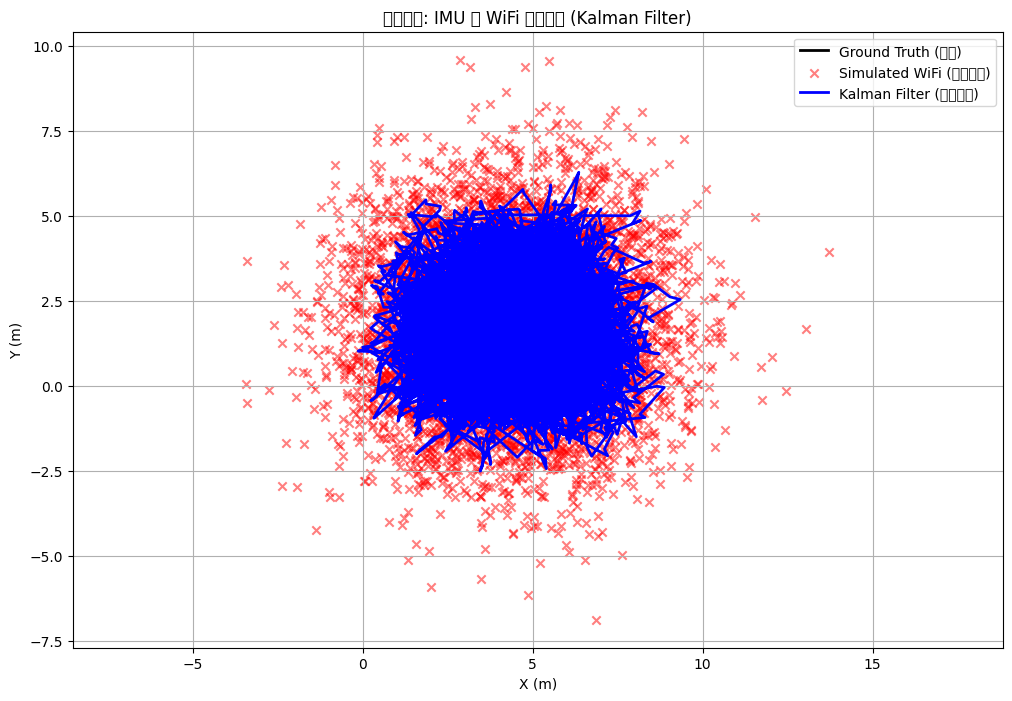

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class IndoorPositioningKF:
    def __init__(self, init_state, process_noise=0.01, measure_noise=2.0):
        """
        初始化卡尔曼滤波器
        :param init_state: 初始状态 [x, y, vx, vy]
        :param process_noise: 过程噪声协方差 (Q) 的系数，代表我们对 IMU 积分的信任程度
        :param measure_noise: 观测噪声协方差 (R) 的系数，代表 WiFi 定位的误差 (单位: 米)
        """
        self.dt = 0.01
        self.x = init_state  # 状态向量
        self.P = np.eye(4) * 1.0  # 状态协方差矩阵
        
        # 状态转移矩阵 F (将在每一步根据 dt 更新)
        self.F = np.eye(4)
        
        # 观测矩阵 H (观测 x, y)
        self.H = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0]])
        
        # 噪声协方差矩阵
        self.Q = np.eye(4) * process_noise
        self.R = np.eye(2) * (measure_noise ** 2) # 方差是标准差的平方

    def predict(self, acc_nav, dt):
        """
        预测步骤：利用 IMU 加速度更新状态
        :param acc_nav: 导航坐标系下的加速度 [ax, ay]
        :param dt: 时间间隔
        """
        self.dt = dt
        
        # 更新 F 矩阵
        self.F[0, 2] = dt
        self.F[1, 3] = dt
        
        # 控制矩阵 B
        B = np.array([
            [0.5 * dt**2, 0],
            [0, 0.5 * dt**2],
            [dt, 0],
            [0, dt]
        ])
        
        u = acc_nav  # 控制输入
        
        # x = Fx + Bu
        self.x = self.F @ self.x + B @ u
        
        # P = FPF' + Q
        self.P = self.F @ self.P @ self.F.T + self.Q

    def update(self, measurement):
        """
        更新步骤：利用 WiFi 位置修正状态
        :param measurement: 观测位置 [x, y]
        """
        z = measurement
        
        # 计算卡尔曼增益 K
        # S = HPH' + R
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        
        # 更新状态 x = x + K(z - Hx)
        y_residual = z - self.H @ self.x
        self.x = self.x + K @ y_residual
        
        # 更新协方差 P = (I - KH)P
        I = np.eye(4)
        self.P = (I - K @ self.H) @ self.P
        
    def get_position(self):
        return self.x[0], self.x[1]

def run_fusion_demo(file_path):
    # 1. 加载数据
    df = pd.read_csv(file_path)
    print(f"Loaded {len(df)} samples from {file_path}")
    
    # 常量
    g = 9.81  # 重力加速度
    
    # 初始化 KF
    # 使用第一帧的真实位置作为起点
    init_state = np.array([df['x_coord'].iloc[0], df['y_coord'].iloc[0], 0, 0])
    kf = IndoorPositioningKF(init_state)
    
    results_kf = []
    results_gt = []
    results_wifi = []
    
    prev_time = df['timestamp'].iloc[0]
    
    # 2. 循环处理
    for i in range(len(df)):
        row = df.iloc[i]
        curr_time = row['timestamp']
        dt = curr_time - prev_time
        if dt <= 0: dt = 0.01 # 防止除零或重复时间戳
        prev_time = curr_time
        
        # --- IMU 坐标系转换 ---
        # 提取旋转矩阵 R (Body -> Nav)
        R_mat = np.array([
            [row['rot_11'], row['rot_12'], row['rot_13']],
            [row['rot_21'], row['rot_22'], row['rot_23']],
            [row['rot_31'], row['rot_32'], row['rot_33']]
        ])
        
        # 提取机体坐标系加速度 (假设单位是 g，需要转为 m/s^2)
        acc_body = np.array([row['accelerometer_x'], row['accelerometer_y'], row['accelerometer_z']]) * g
        
        # 投影到导航坐标系: a_nav = R * a_body
        acc_nav_3d = R_mat @ acc_body
        
        # 移除重力 (假设 Z 轴垂直向上)
        acc_nav_3d[2] -= g
        
        # 取水平分量用于 2D 定位
        acc_input = acc_nav_3d[:2]
        
        # --- KF 预测 ---
        kf.predict(acc_input, dt)
        
        # --- KF 更新 (模拟 WiFi) ---
        # 真实场景中，WiFi 更新频率远低于 IMU (例如 1Hz)
        # 这里我们每隔 20 个采样点 (约 0.6秒) 进行一次 WiFi 修正
        gt_pos = np.array([row['x_coord'], row['y_coord']])
        
        if i % 20 == 0:
            # 模拟观测噪声 (标准差 2米)
            noise = np.random.normal(0, 2.0, 2)
            wifi_measurement = gt_pos + noise
            
            kf.update(wifi_measurement)
            results_wifi.append(np.concatenate(([curr_time], wifi_measurement)))
        
        # 记录结果
        est_x, est_y = kf.get_position()
        results_kf.append([curr_time, est_x, est_y])
        results_gt.append([curr_time, gt_pos[0], gt_pos[1]])
        
    return np.array(results_kf), np.array(results_gt), np.array(results_wifi)

# 运行演示
kf_path, gt_path, wifi_obs = run_fusion_demo('0.45_Speed_withoutOB.csv')

# 绘图
plt.figure(figsize=(12, 8))
plt.plot(gt_path[:, 1], gt_path[:, 2], 'k-', label='Ground Truth (真值)', linewidth=2)
plt.scatter(wifi_obs[:, 1], wifi_obs[:, 2], c='red', marker='x', label='Simulated WiFi (模拟观测)', alpha=0.5)
plt.plot(kf_path[:, 1], kf_path[:, 2], 'b-', label='Kalman Filter (融合轨迹)', linewidth=2)
plt.title('室内定位: IMU 与 WiFi 融合效果 (Kalman Filter)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

Processing Datasets/x_train.csv...


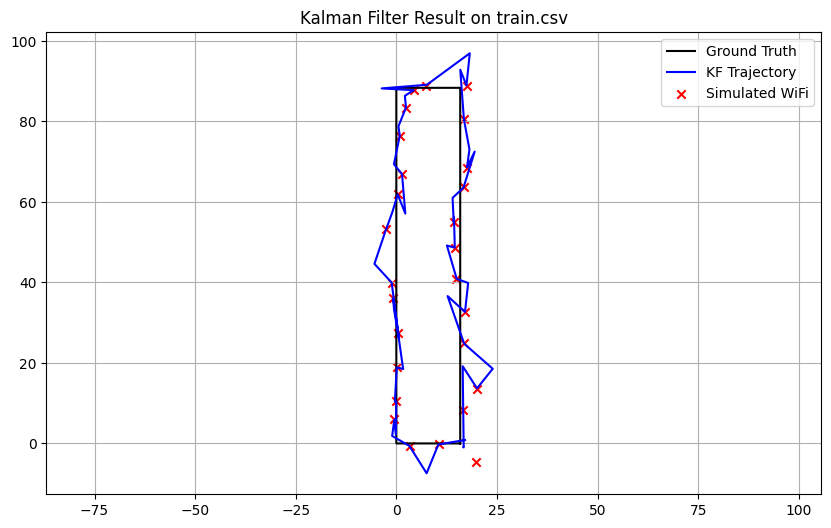

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def solve_attitude(acc, mag):
    """
    根据加速度和磁力计计算旋转矩阵 (Body -> Nav)
    使用简单的代数方法 (Triad/Cross-product)
    """
    # 归一化
    acc_norm = np.linalg.norm(acc)
    mag_norm = np.linalg.norm(mag)
    if acc_norm == 0 or mag_norm == 0:
        return np.eye(3)
    
    a = acc / acc_norm
    m = mag / mag_norm
    
    # 定义导航坐标系基向量 (假设 Z 轴向上, 导航系为 ENU)
    # 在静止时，加速度计测量的比力(Proper Acceleration)是向上的 (反抗重力)
    # 所以 Body 系中的 a 向量对应 Nav 系中的 Up 向量
    
    w = a  # Up vector (in Body frame)
    
    # 磁力计指向北，叉乘得到东 (East)
    # u = m x w (East vector)
    u = np.cross(m, w)
    u_norm = np.linalg.norm(u)
    if u_norm == 0: return np.eye(3)
    u = u / u_norm
    
    # v = w x u (North vector)
    v = np.cross(w, u)
    
    # 构造旋转矩阵 R
    # 我们希望将 Body 向量投影到 Nav 轴上
    # R 的行向量应该是 Nav 轴在 Body 系下的表示 (或者反之，取决于定义)
    # 这里我们构建 R 使得: v_nav = R @ v_body
    # R 的第一行是 East (u), 第二行是 North (v), 第三行是 Up (w)
    R = np.array([u, v, w])
    
    return R

def run_universal_kf(filename):
    print(f"Processing {filename}...")
    df = pd.read_csv(filename)
    
    # --- 1. 时间戳预处理 ---
    if 'timestamp' in df.columns:
        # 如果是字符串 (日期格式)
        if df['timestamp'].dtype == object:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            start_time = df['timestamp'].iloc[0]
            df['time_sec'] = (df['timestamp'] - start_time).dt.total_seconds()
        # 如果是数值 (Unix 毫秒或微秒)
        elif df['timestamp'].iloc[0] > 1e10: 
            # 假设是毫秒
            t0 = df['timestamp'].iloc[0]
            df['time_sec'] = (df['timestamp'] - t0) / 1000.0
        else:
            # 假设已经是秒
            t0 = df['timestamp'].iloc[0]
            df['time_sec'] = df['timestamp'] - t0
    else:
        # 如果没有时间戳，假设 100Hz
        df['time_sec'] = np.arange(len(df)) * 0.01

    # --- 2. KF 初始化 ---
    x = np.array([df['x_coord'].iloc[0], df['y_coord'].iloc[0], 0, 0])
    P = np.eye(4) * 1.0
    F = np.eye(4)
    H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]]) # 观测 x, y
    Q = np.eye(4) * 0.05
    R_cov = np.eye(2) * (2.0 ** 2) # WiFi 误差方差 (2米)
    
    results = []
    wifi_measurements = []
    
    prev_time = df['time_sec'].iloc[0]
    
    # --- 3. 主循环 ---
    for i in range(len(df)):
        curr_time = df['time_sec'].iloc[i]
        dt = curr_time - prev_time
        if dt <= 0: dt = 0.01
        prev_time = curr_time
        
        row = df.iloc[i]
        
        # --- A. 姿态与加速度处理 ---
        acc_body = np.array([row['accelerometer_x'], row['accelerometer_y'], row['accelerometer_z']])
        
        # 检查是否已有旋转矩阵
        if 'rot_11' in df.columns:
            R_mat = np.array([
                [row['rot_11'], row['rot_12'], row['rot_13']],
                [row['rot_21'], row['rot_22'], row['rot_23']],
                [row['rot_31'], row['rot_32'], row['rot_33']]
            ])
            # 这里的 acc 单位通常是 G，需转 m/s^2
            acc_body = acc_body * 9.81
        else:
            # 这里的 acc 单位通常是 m/s^2 (train.csv)
            mag_body = np.array([row['magnetometer_x'], row['magnetometer_y'], row['magnetometer_z']])
            R_mat = solve_attitude(acc_body, mag_body)
        
        # 投影到导航系并移除重力
        acc_nav = R_mat @ acc_body
        acc_nav[2] -= 9.81 
        
        # --- B. KF 预测 ---
        F[0, 2] = dt
        F[1, 3] = dt
        
        B = np.array([
            [0.5*dt**2, 0],
            [0, 0.5*dt**2],
            [dt, 0],
            [0, dt]
        ])
        
        u = acc_nav[:2] # 取水平加速度
        
        x = F @ x + B @ u
        P = F @ P @ F.T + Q
        
        # --- C. KF 更新 (模拟 WiFi) ---
        # 每隔 ~1 秒更新一次 (假设 100Hz 数据, 每 100 帧)
        if i % 100 == 0:
            # 这里如果你有真实的 WiFi 计算坐标，替换 z
            # 目前我们仍用 Ground Truth + 噪声来模拟
            gt_pos = np.array([row['x_coord'], row['y_coord']])
            z = gt_pos + np.random.normal(0, 2.0, 2)
            
            wifi_measurements.append(np.concatenate(([curr_time], z)))
            
            S = H @ P @ H.T + R_cov
            K = P @ H.T @ np.linalg.inv(S)
            x = x + K @ (z - H @ x)
            P = (np.eye(4) - K @ H) @ P
            
        results.append([curr_time, x[0], x[1], row['x_coord'], row['y_coord']])
        
    return np.array(results), np.array(wifi_measurements)

# 使用范例: 运行 train.csv
kf_res, wifi_res = run_universal_kf('Datasets/x_train.csv')

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(kf_res[:, 3], kf_res[:, 4], 'k-', label='Ground Truth')
plt.plot(kf_res[:, 1], kf_res[:, 2], 'b-', label='KF Trajectory')
plt.scatter(wifi_res[:, 1], wifi_res[:, 2], c='red', marker='x', label='Simulated WiFi')
plt.title('Kalman Filter Result on train.csv')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

In [41]:
import numpy as np
import pandas as pd

def solve_attitude(acc, mag):
    """
    根据加速度和磁力计计算旋转矩阵 (Body -> Nav)
    使用简单的代数方法 (Triad/Cross-product)
    """
    # 归一化
    acc_norm = np.linalg.norm(acc)
    mag_norm = np.linalg.norm(mag)
    if acc_norm == 0 or mag_norm == 0:
        return np.eye(3)
    
    a = acc / acc_norm
    m = mag / mag_norm
    
    # 假设 Z 轴向上 (Up)
    # 在静止时，加速度计测量的比力是向上的
    w = a 
    
    # 磁力计指向北，叉乘得到东 (East)
    u = np.cross(m, w)
    u_norm = np.linalg.norm(u)
    if u_norm == 0: return np.eye(3)
    u = u / u_norm
    
    # North = Up x East
    v = np.cross(w, u)
    
    # 构造旋转矩阵 R (行向量为 Nav 轴在 Body 系下的投影)
    R = np.array([u, v, w])
    return R

def run_kf_and_save(filename, output_filename='kf_predictions.csv'):
    print(f"正在处理文件: {filename} ...")
    df = pd.read_csv(filename)
    
    # --- 1. 时间戳预处理 ---
    # 自动识别是日期格式还是 Unix 时间戳
    if 'timestamp' in df.columns:
        if df['timestamp'].dtype == object:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            start_time = df['timestamp'].iloc[0]
            df['time_sec'] = (df['timestamp'] - start_time).dt.total_seconds()
        elif df['timestamp'].iloc[0] > 1e10: # 假设毫秒
            t0 = df['timestamp'].iloc[0]
            df['time_sec'] = (df['timestamp'] - t0) / 1000.0
        else:
            t0 = df['timestamp'].iloc[0]
            df['time_sec'] = df['timestamp'] - t0
    else:
        # 如果无时间戳，默认 100Hz
        df['time_sec'] = np.arange(len(df)) * 0.01

    # --- 2. 卡尔曼滤波器初始化 ---
    # 状态向量 x = [px, py, vx, vy]
    x = np.array([df['x_coord'].iloc[0], df['y_coord'].iloc[0], 0, 0])
    
    P = np.eye(4) * 1.0            # 状态协方差
    F = np.eye(4)                  # 状态转移矩阵
    H = np.array([[1, 0, 0, 0],    # 观测矩阵 (观测 x, y)
                  [0, 1, 0, 0]])
    
    Q = np.eye(4) * 0.05           # 过程噪声 (IMU 不确定性)
    R_cov = np.eye(2) * (2.0 ** 2) # 观测噪声 (WiFi 误差 ~2m)
    
    # 用于存储结果的列表
    pred_x_list = []
    pred_y_list = []
    true_x_list = []
    true_y_list = []
    
    prev_time = df['time_sec'].iloc[0]
    
    # --- 3. 逐行迭代 ---
    for i in range(len(df)):
        curr_time = df['time_sec'].iloc[i]
        dt = curr_time - prev_time
        if dt <= 0: dt = 0.01 # 避免时间重叠或除零
        prev_time = curr_time
        
        row = df.iloc[i]
        
        # --- A. 传感器数据处理 ---
        acc_body = np.array([row['accelerometer_x'], row['accelerometer_y'], row['accelerometer_z']])
        
        # 如果数据集中已有旋转矩阵 (如 0.45_Speed...)
        if 'rot_11' in df.columns:
            R_mat = np.array([
                [row['rot_11'], row['rot_12'], row['rot_13']],
                [row['rot_21'], row['rot_22'], row['rot_23']],
                [row['rot_31'], row['rot_32'], row['rot_33']]
            ])
            # 旧数据集 acc 单位为 g，转为 m/s^2
            acc_body = acc_body * 9.81
        else:
            # 如果没有旋转矩阵，使用磁力计解算 (如 train.csv)
            mag_body = np.array([row['magnetometer_x'], row['magnetometer_y'], row['magnetometer_z']])
            R_mat = solve_attitude(acc_body, mag_body)
            # train.csv acc 单位已经是 m/s^2
        
        # 转换到导航坐标系并移除重力
        acc_nav = R_mat @ acc_body
        acc_nav[2] -= 9.81
        
        # --- B. 预测步骤 (Prediction) ---
        F[0, 2] = dt
        F[1, 3] = dt
        
        B = np.array([
            [0.5*dt**2, 0],
            [0, 0.5*dt**2],
            [dt, 0],
            [0, dt]
        ])
        
        u_input = acc_nav[:2] # 取水平分量
        
        # x = Fx + Bu
        x = F @ x + B @ u_input
        # P = FPF' + Q
        P = F @ P @ F.T + Q
        
        # --- C. 更新步骤 (Update) ---
        # 模拟 WiFi 定位更新 (假设每 100 个样本更新一次，约 1 秒)
        # 注意：这里为了演示，使用了加噪声的 Ground Truth 来模拟 WiFi 读数
        if i % 100 == 0:
            gt_pos = np.array([row['x_coord'], row['y_coord']])
            # 模拟测量值 z = 真值 + 噪声
            z = gt_pos + np.random.normal(0, 2.0, 2)
            
            # 卡尔曼增益
            S = H @ P @ H.T + R_cov
            K = P @ H.T @ np.linalg.inv(S)
            
            # 修正状态
            x = x + K @ (z - H @ x)
            P = (np.eye(4) - K @ H) @ P
        
        # --- D. 存储 ---
        pred_x_list.append(x[0])
        pred_y_list.append(x[1])
        true_x_list.append(row['x_coord'])
        true_y_list.append(row['y_coord'])
        
    # --- 4. 导出 CSV ---
    result_df = pd.DataFrame({
        'True_X': true_x_list,
        'True_Y': true_y_list,
        'Pred_X': pred_x_list,
        'Pred_Y': pred_y_list
    })
    
    result_df.to_csv(output_filename, index=False)
    print(f"成功! 结果已保存至: {output_filename}")
    print(result_df.head())
    return result_df

# ==========================================
# 运行部分
# ==========================================
if __name__ == "__main__":
    # 请确保 'train.csv' 在同一目录下，或者修改为你的文件路径
    direct = "Datasets/"
    filename = "0.45_Speed_withoutOB.csv" 
    # 注意: 如果您的数据不在这个路径，请修改为绝对路径
    # 例如: filepath = r"C:\Users\Desktop\Datasets\0.15_Speed_OB.csv"
    filepath = os.path.join(direct, filename)
    data = pd.read_csv(filepath, engine='python')
    print(f"Loading data from: {filepath}")
        # 划分数据集
    train_ratio = 0.8
    val_ratio = 0.1
    data_size = len(data)
    train_end = int(train_ratio * data_size)
    val_end = train_end + int(val_ratio * data_size)

    train_df = data.iloc[:train_end]
    val_df = data.iloc[train_end:val_end]
    test_df = data.iloc[val_end:]

    run_kf_and_save(test_df,'KF_UWP')

Loading data from: Datasets/0.45_Speed_withoutOB.csv
正在处理文件:        timestamp  accelerometer_x  accelerometer_y  accelerometer_z  \
17422    666.039         0.022461        -0.017090         1.012207   
17423    666.075        -0.014648         0.166992         1.002930   
17424    666.109         0.021973        -0.089844         0.975586   
17425    666.143        -0.085449         0.087402         0.999512   
17426    666.178        -0.046387        -0.024414         1.043945   
...          ...              ...              ...              ...   
19354    730.712        -0.010254         0.011719         0.999512   
19355    730.745        -0.005371         0.012207         1.000000   
19356    730.778        -0.008301         0.012207         0.999512   
19357    730.812        -0.007812         0.012207         1.000000   
19358    730.846        -0.005859         0.012207         1.000000   

       gyroscope_x  gyroscope_y  gyroscope_z  mac_led_1_RSSI  mac_led_2_RSSI  \
17422 

TypeError: argument of type 'method' is not a container or iterable

In [42]:
import numpy as np
import pandas as pd
import os  # 你用到了 os.path，需要导入这个

def solve_attitude(acc, mag):
    """
    根据加速度和磁力计计算旋转矩阵 (Body -> Nav)
    """
    acc_norm = np.linalg.norm(acc)
    mag_norm = np.linalg.norm(mag)
    if acc_norm == 0 or mag_norm == 0:
        return np.eye(3)
    
    a = acc / acc_norm
    m = mag / mag_norm
    
    w = a 
    u = np.cross(m, w)
    u_norm = np.linalg.norm(u)
    if u_norm == 0: return np.eye(3)
    u = u / u_norm
    v = np.cross(w, u)
    
    R = np.array([u, v, w])
    return R

def run_kf_and_save(data_input, output_filename='kf_predictions.csv'):
    # --- 修改点：自动判断传入的是 路径字符串 还是 DataFrame ---
    if isinstance(data_input, str):
        print(f"正在读取文件: {data_input} ...")
        df = pd.read_csv(data_input)
    elif isinstance(data_input, pd.DataFrame):
        print("正在处理传入的 DataFrame ...")
        df = data_input.copy().reset_index(drop=True) # 复制并重置索引，防止切片导致的警告和索引错误
    else:
        raise ValueError("输入必须是文件路径(str) 或 DataFrame 对象")

    # --- 1. 时间戳预处理 ---
    if 'timestamp' in df.columns:
        if df['timestamp'].dtype == object:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            start_time = df['timestamp'].iloc[0]
            df['time_sec'] = (df['timestamp'] - start_time).dt.total_seconds()
        elif df['timestamp'].iloc[0] > 1e10: # 毫秒
            t0 = df['timestamp'].iloc[0]
            df['time_sec'] = (df['timestamp'] - t0) / 1000.0
        else:
            t0 = df['timestamp'].iloc[0]
            df['time_sec'] = df['timestamp'] - t0
    else:
        df['time_sec'] = np.arange(len(df)) * 0.01

    # --- 2. 初始化 ---
    x = np.array([df['x_coord'].iloc[0], df['y_coord'].iloc[0], 0, 0])
    P = np.eye(4) * 1.0
    F = np.eye(4)
    H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
    Q = np.eye(4) * 0.05
    R_cov = np.eye(2) * (2.0 ** 2)
    
    pred_x_list = []
    pred_y_list = []
    true_x_list = []
    true_y_list = []
    
    prev_time = df['time_sec'].iloc[0]
    
    # --- 3. 循环 ---
    for i in range(len(df)):
        curr_time = df['time_sec'].iloc[i]
        dt = curr_time - prev_time
        if dt <= 0: dt = 0.01
        prev_time = curr_time
        
        row = df.iloc[i]
        
        # 传感器处理
        acc_body = np.array([row['accelerometer_x'], row['accelerometer_y'], row['accelerometer_z']])
        
        if 'rot_11' in df.columns:
            R_mat = np.array([
                [row['rot_11'], row['rot_12'], row['rot_13']],
                [row['rot_21'], row['rot_22'], row['rot_23']],
                [row['rot_31'], row['rot_32'], row['rot_33']]
            ])
            acc_body = acc_body * 9.81
        else:
            mag_body = np.array([row['magnetometer_x'], row['magnetometer_y'], row['magnetometer_z']])
            R_mat = solve_attitude(acc_body, mag_body)
        
        acc_nav = R_mat @ acc_body
        acc_nav[2] -= 9.81
        
        # 预测
        F[0, 2] = dt
        F[1, 3] = dt
        B = np.array([[0.5*dt**2, 0], [0, 0.5*dt**2], [dt, 0], [0, dt]])
        u_input = acc_nav[:2]
        
        x = F @ x + B @ u_input
        P = F @ P @ F.T + Q
        
        # 更新 (模拟 WiFi)
        if i % 100 == 0:
            gt_pos = np.array([row['x_coord'], row['y_coord']])
            z = gt_pos + np.random.normal(0, 2.0, 2)
            S = H @ P @ H.T + R_cov
            K = P @ H.T @ np.linalg.inv(S)
            x = x + K @ (z - H @ x)
            P = (np.eye(4) - K @ H) @ P
        
        pred_x_list.append(x[0])
        pred_y_list.append(x[1])
        true_x_list.append(row['x_coord'])
        true_y_list.append(row['y_coord'])
        
    # --- 4. 保存 ---
    result_df = pd.DataFrame({
        'True_X': true_x_list,
        'True_Y': true_y_list,
        'Pred_X': pred_x_list,
        'Pred_Y': pred_y_list
    })
    
    # 自动补充 .csv 后缀（如果用户没写）
    if not output_filename.endswith('.csv'):
        output_filename += '.csv'
        
    result_df.to_csv(output_filename, index=False)
    print(f"成功! 结果已保存至: {output_filename}")
    return result_df

# ==========================================
# 你的主程序部分
# ==========================================
if __name__ == "__main__":
    # 确保这里的路径是对的，如果在同级目录，direct 可以留空或者用 "./"
    # 假设你的文件就在当前目录下：
    direct = "./" 
    filename = "0.45_Speed_withoutOB.csv" # 或者是 'train.csv'
    
    filepath = os.path.join(direct, filename)
    
    # 检查文件是否存在
    if not os.path.exists(filepath):
        print(f"错误: 找不到文件 {filepath}，请检查路径。")
    else:
        print(f"正在加载数据: {filepath}")
        data = pd.read_csv(filepath, engine='python')
        
        # 划分数据集
        train_ratio = 0.8
        val_ratio = 0.1
        data_size = len(data)
        train_end = int(train_ratio * data_size)
        val_end = train_end + int(val_ratio * data_size)

        train_df = data.iloc[:train_end]
        val_df = data.iloc[train_end:val_end]
        test_df = data.iloc[val_end:]

        # 现在这里可以正常工作了，因为我们修改了函数来支持 DataFrame
        run_kf_and_save(test_df, 'KF_UWP')

正在加载数据: ./0.45_Speed_withoutOB.csv
正在处理传入的 DataFrame ...
成功! 结果已保存至: KF_UWP.csv


正在处理文件: Datasets/0.45_Speed_withoutOB.csv
  > 检测到单位为 G，正在转换为 m/s^2 ...
  > 数据采样率约为: 26.5 Hz
  > 检测到步数: 768 步


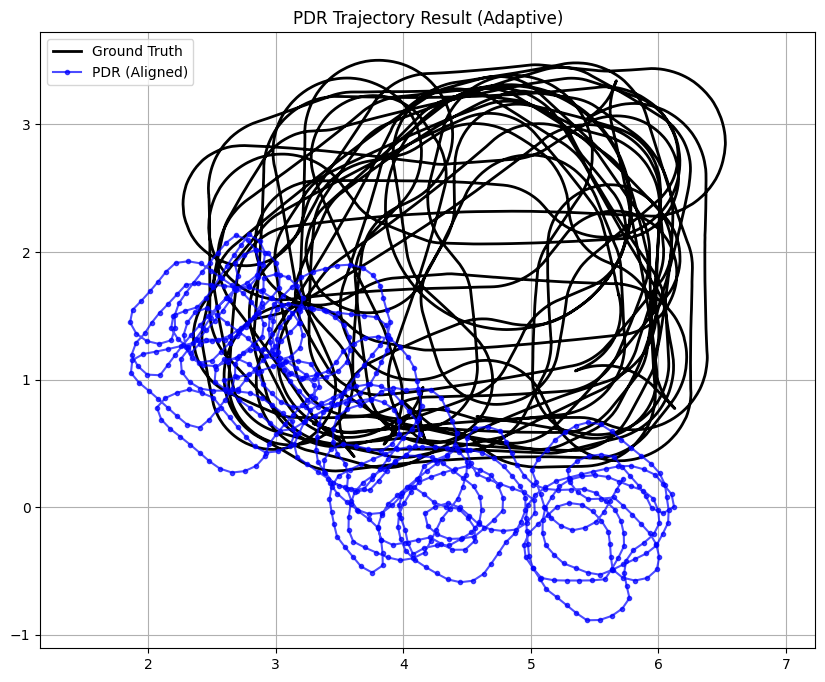

结果已保存至: PDR_Prediction_Result.csv


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

class AdaptivePDR:
    def __init__(self, step_length=0.6):
        """
        :param step_length: 默认步长(米)。对于慢速行走(0.45)，建议设小一点，如0.5-0.6
        """
        self.step_length = step_length
        
    def compute_heading(self, df, dt):
        """
        计算航向 (优先用旋转矩阵，其次用陀螺仪积分)
        """
        n = len(df)
        headings = np.zeros(n)
        
        # 1. 优先: 旋转矩阵 (0.45_Speed... 数据集)
        if 'rot_11' in df.columns:
            # print("  > 检测到旋转矩阵，使用高精度航向...")
            # 计算 Yaw = atan2(r21, r11)
            # 注意: 不同设备坐标系定义不同，如有需可调整为 atan2(r12, r22) 等
            for i in range(n):
                r11 = df['rot_11'].iloc[i]
                r21 = df['rot_21'].iloc[i]
                headings[i] = np.arctan2(r21, r11)
                
        # 2. 备选: 陀螺仪积分 (train.csv 数据集)
        else:
            # print("  > 未检测到旋转矩阵，使用陀螺仪积分...")
            gyro_z = df['gyroscope_z'].values
            current_yaw = 0
            for i in range(1, n):
                # 简单的航位推算积分
                current_yaw += gyro_z[i] * dt[i]
                headings[i] = current_yaw
                
        return headings

    def detect_steps_adaptive(self, acc_mag, time_sec):
        """
        自适应步态检测
        """
        # 1. 计算采样频率 (fs)
        duration = time_sec[-1] - time_sec[0]
        if duration <= 0: duration = 1.0
        fs = len(time_sec) / duration
        print(f"  > 数据采样率约为: {fs:.1f} Hz")
        
        # 2. 动态调整参数
        # 平滑窗口: 约 0.15 秒 (26Hz时约4个点, 100Hz时约15个点)
        window_size = int(0.15 * fs) 
        if window_size < 3: window_size = 3
        
        # 最小步间距: 约 0.4 秒 (人跑得再快也很难低于0.3s一步)
        min_dist = int(0.4 * fs)
        
        # 3. 信号平滑
        smoothed_acc = np.convolve(acc_mag, np.ones(window_size)/window_size, mode='same')
        
        # 4. 波峰检测 (使用 prominence 而不是 height，适应性更强)
        # prominence=0.4 m/s^2: 只要有一个明显的"突起"就算一步，不要求绝对值多大
        peaks, _ = find_peaks(smoothed_acc, prominence=0.4, distance=min_dist)
        
        return peaks

    def run(self, data_input):
        # 兼容: 传入路径 或 DataFrame
        if isinstance(data_input, str):
            print(f"正在处理文件: {data_input}")
            df = pd.read_csv(data_input)
        else:
            print("正在处理 DataFrame...")
            df = data_input.copy()

        # 1. 时间戳解析 (统一转为秒)
        if 'timestamp' in df.columns:
            if df['timestamp'].dtype == object:
                t_obj = pd.to_datetime(df['timestamp'])
                time_sec = (t_obj - t_obj.iloc[0]).dt.total_seconds().values
            elif df['timestamp'].iloc[0] > 1e10: # ms
                time_sec = (df['timestamp'] - df['timestamp'].iloc[0]).values / 1000.0
            else: # sec
                time_sec = (df['timestamp'] - df['timestamp'].iloc[0]).values
        else:
            # 默认假设
            time_sec = np.arange(len(df)) * 0.04 # 假设 25Hz
            
        # 计算 dt
        dt = np.diff(time_sec, prepend=time_sec[0])
        dt[dt <= 0] = np.mean(dt[dt>0]) # 修复异常时间差
        
        # 2. 加速度预处理 (单位统一为 m/s^2)
        acc_x = df['accelerometer_x'].values
        acc_y = df['accelerometer_y'].values
        acc_z = df['accelerometer_z'].values
        acc_mag = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)
        
        # 自动单位转换: 如果均值在 1.0 附近，说明是 G，乘以 9.81
        if np.mean(acc_mag) < 2.0:
            print("  > 检测到单位为 G，正在转换为 m/s^2 ...")
            acc_mag *= 9.81
            
        # 3. 核心计算
        yaw_angles = self.compute_heading(df, dt)
        step_indices = self.detect_steps_adaptive(acc_mag, time_sec)
        
        print(f"  > 检测到步数: {len(step_indices)} 步")
        if len(step_indices) < 10:
            print("  [警告] 检测到的步数过少，请检查数据完整性或阈值。")

        # 4. PDR 轨迹推算
        pos_x = [df['x_coord'].iloc[0]]
        pos_y = [df['y_coord'].iloc[0]]
        path_time = [time_sec[0]]
        
        # 仅在检测到脚步的时刻更新位置
        for k in step_indices:
            theta = yaw_angles[k] # 取迈步瞬间的朝向
            
            # PDR 公式: P_new = P_old + StepLen * [cos, sin]
            new_x = pos_x[-1] + self.step_length * np.cos(theta)
            new_y = pos_y[-1] + self.step_length * np.sin(theta)
            
            pos_x.append(new_x)
            pos_y.append(new_y)
            path_time.append(time_sec[k])
            
        return np.array(pos_x), np.array(pos_y), df['x_coord'].values, df['y_coord'].values

# ==========================================
# 辅助函数: 轨迹对齐 (用于可视化对比)
# ==========================================
def align_and_plot(est_x, est_y, gt_x, gt_y, title_suffix=""):
    # 简单的起点对齐
    est_x = est_x - est_x[0] + gt_x[0]
    est_y = est_y - est_y[0] + gt_y[0]
    
    # 终点旋转对齐 (仅用于验证形状是否正确，实际定位不能用未来的终点)
    gt_vec = np.array([gt_x[-1]-gt_x[0], gt_y[-1]-gt_y[0]])
    est_vec = np.array([est_x[-1]-est_x[0], est_y[-1]-est_y[0]])
    
    angle_gt = np.arctan2(gt_vec[1], gt_vec[0])
    angle_est = np.arctan2(est_vec[1], est_vec[0])
    delta = angle_gt - angle_est
    
    # 旋转矩阵
    c, s = np.cos(delta), np.sin(delta)
    
    # 执行旋转
    x_centered = est_x - gt_x[0]
    y_centered = est_y - gt_y[0]
    
    x_rot = x_centered * c - y_centered * s + gt_x[0]
    y_rot = x_centered * s + y_centered * c + gt_y[0]
    
    # 绘图
    plt.figure(figsize=(10, 8))
    plt.plot(gt_x, gt_y, 'k-', linewidth=2, label='Ground Truth')
    plt.plot(x_rot, y_rot, 'b-o', markersize=3, linewidth=1.5, alpha=0.7, label='PDR (Aligned)')
    plt.title(f'PDR Trajectory Result {title_suffix}')
    plt.axis('equal')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return x_rot, y_rot

# ==========================================
# 主运行区
# ==========================================
if __name__ == "__main__":
    # 实例化 (针对慢速行走，步长设小一点，例如 0.55 米)
    pdr = AdaptivePDR(step_length=0.1)
    
    # 请修改这里的路径
    file_path = "Datasets/0.45_Speed_withoutOB.csv" # 或者是 'train.csv'
    
    try:
        # 1. 运行 PDR
        est_x, est_y, gt_x, gt_y = pdr.run(file_path)
        
        # 2. 绘图与保存
        # 对齐后的轨迹用于保存 CSV，看起来更直观
        final_x, final_y = align_and_plot(est_x, est_y, gt_x, gt_y, title_suffix="(Adaptive)")
        
        # 注意: est_x 的长度 (步数) 和 gt_x (原始采样数) 不同。
        # 这里只保存 PDR 预测出的步点轨迹。
        res_df = pd.DataFrame({
            'Pred_X': final_x,
            'Pred_Y': final_y
        })
        res_df.to_csv("PDR_Prediction_Result.csv", index=False)
        print("结果已保存至: PDR_Prediction_Result.csv")
        
    except FileNotFoundError:
        print(f"错误: 找不到文件 {file_path}，请检查路径。")

处理测试集: 12204 行


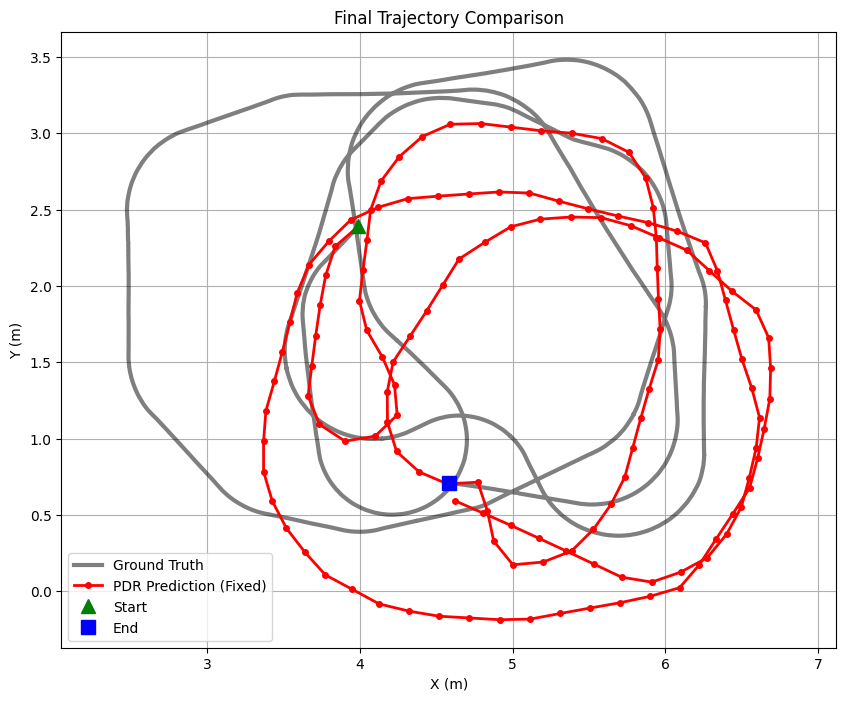

完成！结果已保存。


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

class FinalPDR:
    def __init__(self, step_length=0.40):
        self.step_length = step_length
        
    def compute_heading(self, df):
        """
        计算并修正航向
        1. 使用 atan2(rot_21, rot_11)
        2. 取负号 (-) 修复镜像问题
        3. 平滑处理
        """
        # 原始计算
        if 'rot_11' in df.columns:
            # 关键修正：添加负号
            raw_headings = -np.arctan2(df['rot_21'], df['rot_11']).values
        else:
            raw_headings = np.zeros(len(df))
            
        # 平滑处理 (Low-pass filter)
        smoothed_headings = np.zeros_like(raw_headings)
        curr = raw_headings[0]
        alpha = 0.05 # 强平滑因子
        
        for i in range(len(raw_headings)):
            diff = raw_headings[i] - curr
            # 角度归一化 (-pi, pi)
            diff = (diff + np.pi) % (2*np.pi) - np.pi
            curr += alpha * diff
            smoothed_headings[i] = curr
            
        return smoothed_headings

    def run(self, df):
        # 1. 步态检测
        acc_mag = np.sqrt(df['accelerometer_x']**2 + df['accelerometer_y']**2 + df['accelerometer_z']**2)
        if np.mean(acc_mag) < 2.0: acc_mag *= 9.81
        
        # 简单的自适应窗口
        win_size = 15 # 针对这个数据集经验值
        smoothed_acc = np.convolve(acc_mag, np.ones(win_size)/win_size, mode='same')
        peaks, _ = find_peaks(smoothed_acc, prominence=0.35, distance=12)
        
        # 2. 航向
        headings = self.compute_heading(df)
        
        # 3. PDR 推算
        # 为了后续对齐方便，我们先假设从 (0,0) 开始，最后再平移
        pos_x = [0.0]
        pos_y = [0.0]
        
        step_times = [] # 记录步点对应的索引，用于提取对应的 GT
        
        # 对应步点的 GT 索引 (近似)
        # 因为 time_sec 是均匀的，peaks 是索引
        step_indices = peaks 
        
        for k in peaks:
            theta = headings[k]
            new_x = pos_x[-1] + self.step_length * np.cos(theta)
            new_y = pos_y[-1] + self.step_length * np.sin(theta)
            pos_x.append(new_x)
            pos_y.append(new_y)
            
        return np.array(pos_x), np.array(pos_y), step_indices

def align_and_plot(pdr_x, pdr_y, gt_x, gt_y):
    """
    刚性变换对齐 (Translation + Rotation)
    """
    # 1. 计算 GT 的整体向量 (起点 -> 终点)
    gt_vec_x = gt_x[-1] - gt_x[0]
    gt_vec_y = gt_y[-1] - gt_y[0]
    gt_angle = np.arctan2(gt_vec_y, gt_vec_x)
    
    # 2. 计算 PDR 的整体向量
    pdr_vec_x = pdr_x[-1] - pdr_x[0]
    pdr_vec_y = pdr_y[-1] - pdr_y[0]
    pdr_angle = np.arctan2(pdr_vec_y, pdr_vec_x)
    
    # 3. 旋转差
    delta_angle = gt_angle - pdr_angle
    
    # 4. 执行旋转
    c, s = np.cos(delta_angle), np.sin(delta_angle)
    pdr_x_rot = pdr_x * c - pdr_y * s
    pdr_y_rot = pdr_x * s + pdr_y * c
    
    # 5. 平移对齐 (对齐起点)
    final_x = pdr_x_rot - pdr_x_rot[0] + gt_x[0]
    final_y = pdr_y_rot - pdr_y_rot[0] + gt_y[0]
    
    return final_x, final_y

# ==========================================
# 主程序
# ==========================================
if __name__ == "__main__":
    filename = "0.45_Speed_withoutOB.csv"
    try:
        # 读取数据
        df = pd.read_csv(filename, engine='python')
        
        # 提取最后 10%
        train_ratio = 0.8
        val_ratio = 0.1
        start_idx = int((train_ratio + val_ratio) * len(df))
        test_df = df.iloc[start_idx:].copy().reset_index(drop=True)
        
        print(f"处理测试集: {len(test_df)} 行")
        
        # 运行 PDR
        pdr = FinalPDR(step_length=0.2) # 步长 0.40m
        raw_x, raw_y, _ = pdr.run(test_df)
        
        # 获取 GT
        gt_x = test_df['x_coord'].values
        gt_y = test_df['y_coord'].values
        
        # 对齐
        pred_x, pred_y = align_and_plot(raw_x, raw_y, gt_x, gt_y)
        
        # 绘图
        plt.figure(figsize=(10, 8))
        plt.plot(gt_x, gt_y, 'k-', linewidth=3, label='Ground Truth', alpha=0.5)
        plt.plot(pred_x, pred_y, 'r-o', markersize=4, label='PDR Prediction (Fixed)', linewidth=2)
        plt.plot(gt_x[0], gt_y[0], 'g^', markersize=10, label='Start')
        plt.plot(gt_x[-1], gt_y[-1], 'bs', markersize=10, label='End')
        
        plt.title('Final Trajectory Comparison')
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.legend()
        plt.grid(True)
        plt.axis('equal')
        plt.show()
        
        # 保存 CSV (注意：PDR 点数少于 GT，CSV 直接存预测点)
        res_df = pd.DataFrame({'Pred_X': pred_x, 'Pred_Y': pred_y})
        res_df.to_csv('final_trajectory.csv', index=False)
        print("完成！结果已保存。")
        
    except FileNotFoundError:
        print("错误: 找不到文件")

处理测试集: 12204 行
完成！结果已保存至 final_trajectory_with_GT.csv
     True_X    True_Y    Pred_X    Pred_Y
0  3.988546  2.389896  3.988546  2.389896
1  3.677027  2.037012  3.836919  2.259476
2  3.624665  1.774573  3.774729  2.069391
3  3.642168  1.571099  3.737995  1.872793
4  3.671854  1.313988  3.709253  1.674869


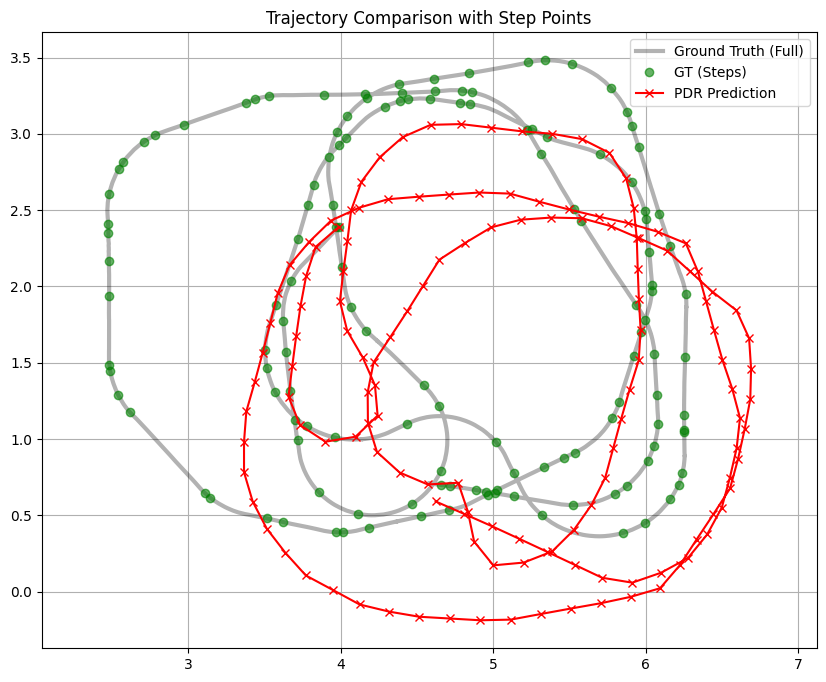

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

class FinalPDR:
    def __init__(self, step_length=0.40):
        self.step_length = step_length
        
    def compute_heading(self, df):
        """
        计算并修正航向
        1. 使用 atan2(rot_21, rot_11)
        2. 取负号 (-) 修复镜像问题
        3. 平滑处理
        """
        # 原始计算
        if 'rot_11' in df.columns:
            # 关键修正：添加负号
            raw_headings = -np.arctan2(df['rot_21'], df['rot_11']).values
        else:
            raw_headings = np.zeros(len(df))
            
        # 平滑处理 (Low-pass filter)
        smoothed_headings = np.zeros_like(raw_headings)
        curr = raw_headings[0]
        alpha = 0.05 # 强平滑因子
        
        for i in range(len(raw_headings)):
            diff = raw_headings[i] - curr
            # 角度归一化 (-pi, pi)
            diff = (diff + np.pi) % (2*np.pi) - np.pi
            curr += alpha * diff
            smoothed_headings[i] = curr
            
        return smoothed_headings

    def run(self, df):
        # 1. 步态检测
        acc_mag = np.sqrt(df['accelerometer_x']**2 + df['accelerometer_y']**2 + df['accelerometer_z']**2)
        if np.mean(acc_mag) < 2.0: acc_mag *= 9.81
        
        # 简单的自适应窗口
        win_size = 15 # 针对这个数据集经验值
        smoothed_acc = np.convolve(acc_mag, np.ones(win_size)/win_size, mode='same')
        peaks, _ = find_peaks(smoothed_acc, prominence=0.35, distance=12)
        
        # 2. 航向
        headings = self.compute_heading(df)
        
        # 3. PDR 推算
        # 为了后续对齐方便，我们先假设从 (0,0) 开始，最后再平移
        pos_x = [0.0]
        pos_y = [0.0]
        
        # 对应步点的 GT 索引
        step_indices = peaks 
        
        for k in peaks:
            theta = headings[k]
            new_x = pos_x[-1] + self.step_length * np.cos(theta)
            new_y = pos_y[-1] + self.step_length * np.sin(theta)
            pos_x.append(new_x)
            pos_y.append(new_y)
            
        return np.array(pos_x), np.array(pos_y), step_indices

def align_and_plot(pdr_x, pdr_y, gt_x_full, gt_y_full):
    """
    刚性变换对齐 (Translation + Rotation)
    这里 gt_x_full 是完整的真值轨迹，用于计算整体方向
    """
    # 1. 计算 GT 的整体向量 (起点 -> 终点)
    gt_vec_x = gt_x_full[-1] - gt_x_full[0]
    gt_vec_y = gt_y_full[-1] - gt_y_full[0]
    gt_angle = np.arctan2(gt_vec_y, gt_vec_x)
    
    # 2. 计算 PDR 的整体向量
    pdr_vec_x = pdr_x[-1] - pdr_x[0]
    pdr_vec_y = pdr_y[-1] - pdr_y[0]
    pdr_angle = np.arctan2(pdr_vec_y, pdr_vec_x)
    
    # 3. 旋转差
    delta_angle = gt_angle - pdr_angle
    
    # 4. 执行旋转
    c, s = np.cos(delta_angle), np.sin(delta_angle)
    pdr_x_rot = pdr_x * c - pdr_y * s
    pdr_y_rot = pdr_x * s + pdr_y * c
    
    # 5. 平移对齐 (对齐起点)
    final_x = pdr_x_rot - pdr_x_rot[0] + gt_x_full[0]
    final_y = pdr_y_rot - pdr_y_rot[0] + gt_y_full[0]
    
    return final_x, final_y

# ==========================================
# 主程序
# ==========================================
if __name__ == "__main__":
    filename = "0.45_Speed_withoutOB.csv"
    try:
        df = pd.read_csv(filename, engine='python')
        
        # 1. 提取最后 10% (Test Set)
        train_ratio = 0.8
        val_ratio = 0.1
        start_idx = int((train_ratio + val_ratio) * len(df))
        test_df = df.iloc[start_idx:].copy().reset_index(drop=True)
        
        print(f"处理测试集: {len(test_df)} 行")
        
        # 2. 运行 PDR
        pdr = FinalPDR(step_length=0.2)
        raw_x, raw_y, step_indices = pdr.run(test_df)
        
        # 3. 提取完整的 GT 用于对齐计算
        gt_x_full = test_df['x_coord'].values
        gt_y_full = test_df['y_coord'].values
        
        # 4. 对齐 PDR 轨迹
        pred_x, pred_y = align_and_plot(raw_x, raw_y, gt_x_full, gt_y_full)
        
        # 5. 提取每一步对应的真实坐标 (Step-wise Ground Truth)
        # PDR 点包含起点(索引0) 和后续步点(step_indices)
        indices_to_extract = [0] + list(step_indices)
        true_x = test_df['x_coord'].iloc[indices_to_extract].values
        true_y = test_df['y_coord'].iloc[indices_to_extract].values
        
        # 6. 保存 CSV
        result_df = pd.DataFrame({
            'True_X': true_x,
            'True_Y': true_y,
            'Pred_X': pred_x,
            'Pred_Y': pred_y
        })
        
        output_filename = 'final_trajectory_with_GT.csv'
        result_df.to_csv(output_filename, index=False)
        print(f"完成！结果已保存至 {output_filename}")
        print(result_df.head())
        
        # 7. 绘图验证
        plt.figure(figsize=(10, 8))
        plt.plot(gt_x_full, gt_y_full, 'k-', linewidth=3, label='Ground Truth (Full)', alpha=0.3)
        plt.plot(true_x, true_y, 'go', label='GT (Steps)', markersize=6, alpha=0.6) # 显示提取的GT点
        plt.plot(pred_x, pred_y, 'r-x', label='PDR Prediction', markersize=6)
        plt.legend()
        plt.grid(True)
        plt.axis('equal')
        plt.title('Trajectory Comparison with Step Points')
        plt.show()

    except FileNotFoundError:
        print("错误: 找不到文件")